In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [2]:
torch.manual_seed(423212)

## Loading MNIST

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # transforms.Normalize((0.1307,), (0.3081,))
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ])),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # transforms.Normalize((0.1307,), (0.3081,))
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                   ])),
                    batch_size=10, shuffle=False)

## Helper Functions

In [20]:
def to_img(x):
    x = x.data.numpy()
    x = 0.5 * (x + 1)
    x = np.clip(x, 0, 1)
    x = x.reshape([-1, 28, 28])
    return x

def plot_reconstructions(model, save=True, name=None, conv=False, simple=False):
    # encode then decode
    data, _ = next(iter(test_loader))
    if not conv:
        data = data.view([-1, 784])
    data = Variable(data, volatile=True)
    true_imgs = data
    encoded_imgs = model.encoder(data)
    if simple:
        encoded_imgs = F.relu(encoded_imgs)
    decoded_imgs = model.decoder(encoded_imgs)
    
    true_imgs = to_img(true_imgs)
    decoded_imgs = to_img(decoded_imgs)
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(true_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    if save:
        plt.savefig('./plots/' + name + '.png', format='png', dpi=300)
    plt.show()

## Simple Auto-Encoder

We'll start with the simplest autoencoder: a single, fully-connected layer as the encoder and decoder.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = F.tanh(self.decoder(encoded))
        return decoded, encoded

In [ ]:
input_dim = 784
encoding_dim = 32

model = AutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())

In [ ]:
def l1_penalty(var):
    return torch.abs(var).sum()

def train(epoch, l1_weight=1e-5):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.view([-1, 784]))
        optimizer.zero_grad()
        
        decoder_out, encoder_out = model(data)
        mse_loss = F.mse_loss(decoder_out, data)
        l1_reg = l1_weight * l1_penalty(encoder_out)
        loss = mse_loss + l1_reg

        # output = model(data)
        # loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [ ]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

In [ ]:
plot_reconstructions(model, save=True, name='simple_l1_regularization_tanh', simple=True)

## Stacked Auto-Encoder

In [ ]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(DeepAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, encoding_dim), 
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, input_dim),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
input_dim = 784
encoding_dim = 32

model = DeepAutoEncoder(input_dim, encoding_dim)
optimizer = optim.Adam(model.parameters())

In [8]:
def train(epoch):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data.view([-1, 784]))
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [ ]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

In [ ]:
plot_reconstructions(model, save=True, name='stacked_ae', conv=False, simple=False)

## Convolutional Auto-Encoder

In [5]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.MaxPool2d(2, stride=1),
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh(),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [31]:
model = ConvolutionalAutoEncoder()
optimizer = optim.Adam(model.parameters())

In [32]:
def train(epoch):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [33]:
num_epochs = 30

for epoch in range(1,  num_epochs + 1):
    train(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.804431
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.494042
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.406626
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.352273
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.318693
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.276487
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.264322
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.251988


KeyboardInterrupt: 

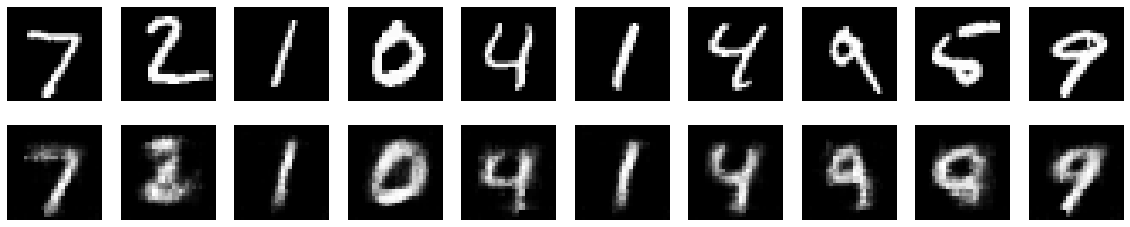

In [26]:
plot_reconstructions(model, save=True, name='conv_ae_tanh', conv=True, simple=False)